In [37]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math

import xgboost as xgb

from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm,tqdm_pandas
tqdm.pandas(tqdm, mininterval=10)

#Disable pandas warnings
pd.options.mode.chained_assignment = None

In [38]:
train=pd.read_csv('/Users/adityavyas/Desktop/Machine_Learning_and_Data_Science/Datasets/Black_Friday/train.csv')
test=pd.read_csv('/Users/adityavyas/Desktop/Machine_Learning_and_Data_Science/Datasets/Black_Friday/test.csv')

In [39]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [40]:
train.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [41]:
train.shape, test.shape

((550068, 12), (233599, 11))

In [42]:
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [43]:
test.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

In [44]:
test_users=test['User_ID'].copy()
test_product=test['Product_ID'].copy()

In [45]:
train['Product_ID'].value_counts()[0:10]

P00265242    1880
P00025442    1615
P00110742    1612
P00112142    1562
P00057642    1470
P00184942    1440
P00046742    1438
P00058042    1422
P00145042    1406
P00059442    1406
Name: Product_ID, dtype: int64

In [46]:
train['User_ID'].value_counts()[0:10]

1001680    1026
1004277     979
1001941     898
1001181     862
1000889     823
1003618     767
1001150     752
1001015     740
1005795     729
1005831     727
Name: User_ID, dtype: int64

In [47]:
#Removing missing values

train['Product_Category_2'].value_counts()

8.0     64088
14.0    55108
2.0     49217
16.0    43255
15.0    37855
5.0     26235
4.0     25677
6.0     16466
11.0    14134
17.0    13320
13.0    10531
9.0      5693
12.0     5528
10.0     3043
3.0      2884
18.0     2770
7.0       626
Name: Product_Category_2, dtype: int64

In [48]:
train['Product_Category_3'].value_counts()

16.0    32636
15.0    28013
14.0    18428
17.0    16702
5.0     16658
8.0     12562
9.0     11579
12.0     9246
13.0     5459
6.0      4890
18.0     4629
4.0      1875
11.0     1805
10.0     1726
3.0       613
Name: Product_Category_3, dtype: int64

In [49]:
train['Product_Category_2'][np.isnan(train['Product_Category_2'])]=train['Product_Category_2'].mode()[0]
train['Product_Category_3'][np.isnan(train['Product_Category_3'])]=train['Product_Category_3'].mode()[0]

test['Product_Category_2'][np.isnan(test['Product_Category_2'])]=test['Product_Category_2'].mode()[0]
test['Product_Category_3'][np.isnan(test['Product_Category_3'])]=test['Product_Category_3'].mode()[0]

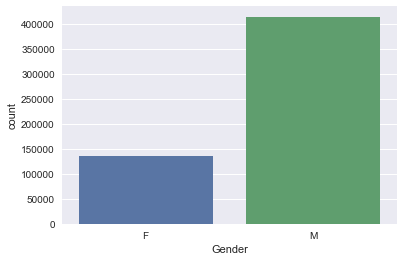

In [50]:
sns.countplot(train['Gender'])

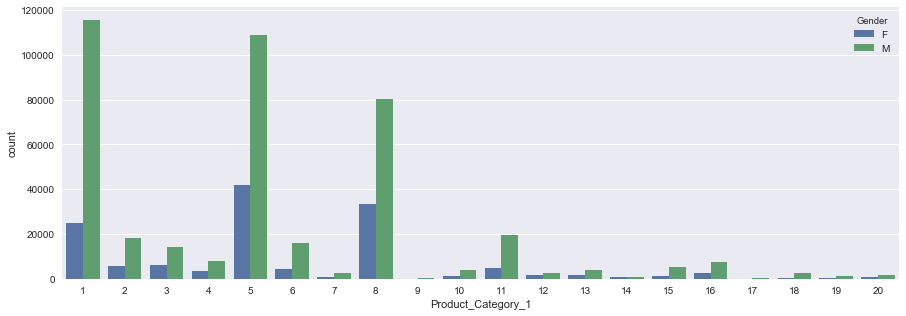

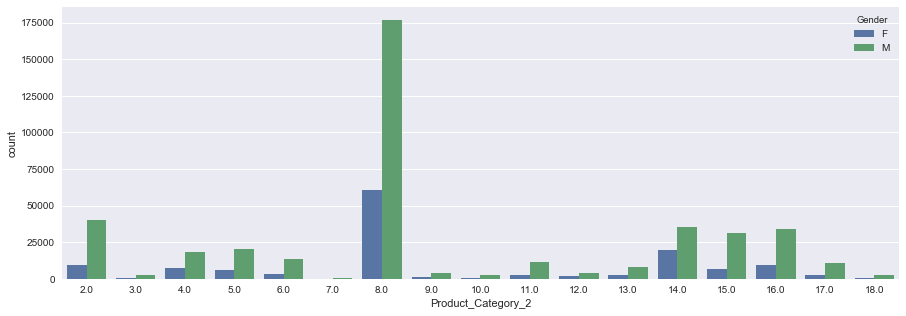

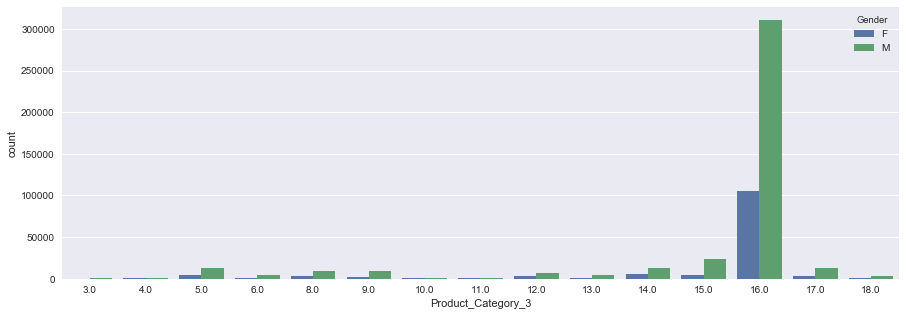

In [51]:
plt.figure(1, figsize=(15,5))
sns.countplot(train['Product_Category_1'], hue=train['Gender'])

plt.figure(2, figsize=(15,5))
sns.countplot(train['Product_Category_2'], hue=train['Gender'])

plt.figure(3, figsize=(15,5))
sns.countplot(train['Product_Category_3'], hue=train['Gender'])

Most of the purchasers are Male and amount of purchase varies across the 3 different categories.

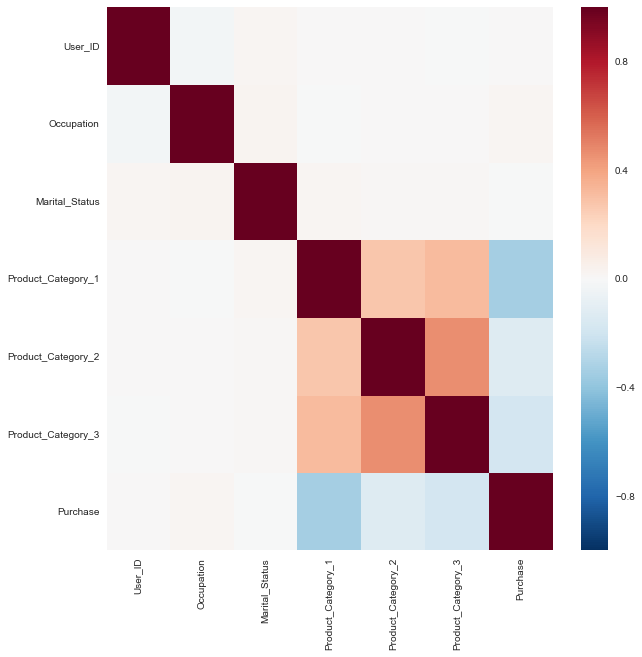

In [52]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr())

We see that all the variables are not correlated to each other. Infact only the different product categories appear to be correlated to each other. Also the target variable Purchase appears to be negatively correlated to the product categories. Let us add some more features

We now look at how each user has purchased in the different product category and how much of the particular product_ID has the user purchased.

In [53]:
train_item_user_counts=train['User_ID'].groupby(train['Product_ID'])
train_user_item_counts=train['Product_ID'].groupby(train['User_ID'])

test_item_user_counts=test['User_ID'].groupby(test['Product_ID'])
test_user_item_counts=test['Product_ID'].groupby(test['User_ID'])

In [54]:
train_user_item_counts.count()

User_ID
1000001     35
1000002     77
1000003     29
1000004     14
1000005    106
1000006     47
1000007     17
1000008     77
1000009     58
1000010    223
1000011     70
1000012     11
1000013     60
1000014     13
1000015    117
1000016     22
1000017    115
1000018    180
1000019    145
1000020     12
1000021     14
1000022    156
1000023    171
1000024     77
1000025     44
1000026    226
1000027     42
1000028     57
1000029     52
1000030     31
          ... 
1006011    105
1006012     16
1006013     75
1006014     59
1006015     32
1006016    504
1006017     18
1006018     82
1006019     54
1006020     23
1006021     69
1006022     27
1006023     88
1006024     60
1006025    151
1006026     47
1006027     23
1006028     28
1006029     17
1006030     59
1006031     31
1006032     55
1006033     36
1006034     12
1006035    152
1006036    514
1006037    122
1006038     12
1006039     74
1006040    180
Name: Product_ID, dtype: int64

In [55]:
train_user_items_dict=dict(train_user_item_counts.count())
test_user_items_dict=dict(test_user_item_counts.count())

def get_item_counts(x,l):
    if l==1:
        return train_user_items_dict[x]
    if l==2:
        return test_user_items_dict[x]

train['user_counts']=train['User_ID'].apply(lambda x: get_item_counts(x,1))
test['user_counts']=test['User_ID'].apply(lambda x: get_item_counts(x,2))


In [56]:
train_item_user_dict=dict(train_item_user_counts.count())
test_item_user_dict=dict(test_item_user_counts.count())

def get_item_user_counts(x,l):
    if l==1:
        return train_item_user_dict[x]
    if l==2:
        return test_item_user_dict[x]

train['item_counts']=train['Product_ID'].apply(lambda x: get_item_user_counts(x,1))
test['item_counts']=test['Product_ID'].apply(lambda x: get_item_user_counts(x,2))

In [57]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,user_counts,item_counts
0,1000001,P00069042,F,0-17,10,A,2,0,3,8.0,16.0,8370,35,227
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,35,581
2,1000001,P00087842,F,0-17,10,A,2,0,12,8.0,16.0,1422,35,102
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,16.0,1057,35,341
4,1000002,P00285442,M,55+,16,C,4+,0,8,8.0,16.0,7969,77,203


In [58]:
lb=LabelEncoder()
train['User_ID']=lb.fit_transform(train['User_ID'])
test['User_ID']=lb.fit_transform(test['User_ID'])

In [59]:
new_products=list(set(pd.unique(test['Product_ID'])) - set(pd.unique(train['Product_ID'])))
test.ix[test['Product_ID'].isin(new_products), 'Product_ID']=-1
new_products.append(-1)
test.ix[~test['Product_ID'].isin(new_products), 'Product_ID'] = lb.fit_transform(test.ix[~test['Product_ID'].isin(new_products), 'Product_ID'])

In [60]:
train['Product_ID']=lb.fit_transform(train['Product_ID'])
train=pd.get_dummies(train)
test=pd.get_dummies(test)

In [61]:
train.head()

,User_ID,Product_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,user_counts,item_counts,...,Age_51-55,Age_55+,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,0,672,10,0,3,8.0,16.0,8370,35,227,...,0,0,1,0,0,0,0,1,0,0
1,0,2376,10,0,1,6.0,14.0,15200,35,581,...,0,0,1,0,0,0,0,1,0,0
2,0,852,10,0,12,8.0,16.0,1422,35,102,...,0,0,1,0,0,0,0,1,0,0
3,0,828,10,0,12,14.0,16.0,1057,35,341,...,0,0,1,0,0,0,0,1,0,0
4,1,2734,16,0,8,8.0,16.0,7969,77,203,...,0,1,0,0,1,0,0,0,0,1


In [78]:
product_purchase=train['Product_ID'].groupby(train['Purchase'])
product_purchase.mean()

Purchase
12       3562.475248
13       3562.641509
14       3562.315789
24       3562.288136
25       3562.920354
26       3562.544643
36       3562.242991
37       3562.409091
38       3562.543860
48       3562.453704
49       3562.252747
50       3563.300000
60       3562.768595
61       3562.941176
62       3562.142857
118      3566.842105
119      3566.750000
120      3566.866667
121      3566.760000
122      3566.941176
123      3566.923077
124      3566.818182
125      3566.666667
126      3566.800000
127      3567.000000
128      3567.200000
129      3566.852941
130      3567.000000
131      3567.045455
132      3567.000000
            ...     
23931     673.000000
23932     948.000000
23933     888.500000
23934    1077.500000
23935    3324.000000
23936     958.750000
23937    1070.000000
23938    1502.000000
23939    1145.800000
23940    2127.000000
23941     707.666667
23942     794.500000
23943    1210.500000
23944     794.500000
23945     519.000000
23946     908.000000
2394

In [62]:
x_train=train.drop('Purchase',1)
y_train=train['Purchase']
x_test=test

In [66]:
xg1=xgb.XGBRegressor(n_estimators=100, max_depth=3)
xg1.fit(x_train, y_train)
pred1=xg1.predict(x_test)

In [67]:
xg2=xgb.XGBRegressor(n_estimators=200, max_depth=4)
xg2.fit(x_train, y_train)
pred2=xg2.predict(x_test)

In [65]:
dtrain = xgb.DMatrix(x_train, label=y_train)

param = {'objective': 'reg:linear', 'booster': 'gbtree', 'silent': 1,
'max_depth': 10, 'eta': 0.1,
'subsample': 0.8, 'colsample_bytree': 0.8,
'max_delta_step': 0, 'gamma': 0}
num_round = 690

test_preds = np.zeros((len(test), len(seeds)))

for run in range(len(seeds)):
    print ("\rXGB RUN:{}/{}".format(run+1, len(seeds)))
    #param['seed'] = seeds[run]
    clf = xgb.train(param, dtrain, num_round)
    dtest = xgb.DMatrix(x_test, missing=np.nan)
    test_preds[:, run] = clf.predict(dtest)

XGB RUN:1/1


KeyboardInterrupt: 

In [68]:
sub=pd.DataFrame()
sub['1']=pred1
sub['2']=pred2
#sub['3']=pred3
#sub['4']=pred4
#sub['5']=pred5
#sub['6']=pred6
#sub['7']=pred7
#sub['8']=pred8
#sub['9']=pred9
#sub['10']=pred10
#sub['11']=pred11

In [69]:
sub['mean']=sub[['1','2']].mean(axis=1)

In [71]:
sub2=pd.DataFrame()
sub2['User_ID']=test_users
sub2['Product_ID']=test_product
sub2['Purchase']=sub['mean']

In [72]:
sub2.to_csv('/Users/adityavyas/Desktop/black_friday.csv',header=True, index=False)

In [73]:
train.columns

Index([u'User_ID', u'Product_ID', u'Occupation', u'Marital_Status',
       u'Product_Category_1', u'Product_Category_2', u'Product_Category_3',
       u'Purchase', u'user_counts', u'item_counts', u'Gender_F', u'Gender_M',
       u'Age_0-17', u'Age_18-25', u'Age_26-35', u'Age_36-45', u'Age_46-50',
       u'Age_51-55', u'Age_55+', u'City_Category_A', u'City_Category_B',
       u'City_Category_C', u'Stay_In_Current_City_Years_0',
       u'Stay_In_Current_City_Years_1', u'Stay_In_Current_City_Years_2',
       u'Stay_In_Current_City_Years_3', u'Stay_In_Current_City_Years_4+'],
      dtype='object')